In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats
import warnings
warnings.filterwarnings(action = 'ignore')
plt.style.use('seaborn')

In [2]:
def dataLoader(path:str, thresh:int = 0.2)->pd.DataFrame:
    '''
    Load the data. Drop cols with null threshold more than thresh param.
    '''
    data = pd.read_csv(path)
    data = data.drop('Id', axis = 1)
    null_cols = data.isnull().sum()[data.isnull().sum()/len(data) > thresh]
    null_cols_list = null_cols.index
    data.drop(null_cols_list, axis = 1, inplace = True)
    data.dropna(inplace = True)
    print(f'data shape: {data.shape}')
    return data

In [3]:
data = dataLoader('train.csv', 0.15)
data.head()

data shape: (1338, 74)


,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [4]:
def dataSeg(data:pd.DataFrame)->pd.DataFrame:
    '''
    Separates the numerical data from cat data.  
    y = Target Series
    num = DataFrame with only numerical values
    cat = DataFrame with only object values
    '''
    input_data = data.drop('SalePrice', axis = 1)
    y  = data['SalePrice']
    num = input_data.select_dtypes(exclude = 'object')
    cat = input_data.select_dtypes(include = 'object')
    
    '''
    Seperates the numerical data suitable for standardization, numerical ordinal data and year data for Target Encoding
    int_data = DataFrame for standardization(columns which had nunique > 50)
    ordinal_data = DataFrame containing ordinal columns(columns which had nunique < 50)
    int_year_data = DataFrame containing year columns 
    '''
    int_data_temp = num.nunique()[(num.nunique()>50) & (~num.columns.str.match('Year|Yr|[A-za-z]+Yr'))]
    ordinal_data_temp = num.nunique()[num.nunique()<50]
    int_year_data_temp = num.nunique()[num.columns.str.match('Year|Yr|[A-za-z]+Yr')]#.astype(str)
    int_data = num.loc[:, int_data_temp.index]
    ordinal_data = num.loc[:, ordinal_data_temp.index]
    int_year_data = num.loc[:, int_year_data_temp.index]
    
    '''
    Seperates the categorical data suitable for OHE and Traget Encoding
    cat_data_ohe = DataFrame containing object data for OHE(columns which had nunique < 10)
    cat_data_tc = DataFrame containing object data for TargetEncoding(columns which had nunique > 10)
    '''
    cat_cols_ohe_temp = cat.nunique()[cat.nunique()<10]
    cat_cols_tc_temp = cat.nunique()[cat.nunique()>10]
    cat_data_ohe = cat.loc[:, cat_cols_ohe_temp.index]
    cat_data_tc = cat.loc[:, cat_cols_tc_temp.index]
    
    
    return y, int_data, ordinal_data, int_year_data, cat_data_ohe, cat_data_tc

In [5]:
y, int_data, ordinal_data, int_year_data, cat_data_ohe, cat_data_tc = dataSeg(data)

In [6]:
def removeOutliers(data: pd.DataFrame)->pd.DataFrame:
    
    iqr = data.apply(lambda x: stats.iqr(x))
    q3 = data.apply(lambda x: x.quantile(0.75))
    q1 = data.apply(lambda x: x.quantile(0.25))
    ul = q3 + 1.5 * iqr
    ll = q1 - 1.5 * iqr
    try:
        assert len(ul) == len(ll)
        new_data = data.apply(lambda x: [x.median() if (i > ul[x.name] or i < ll[x.name]) else i for i in x])
    except AssertionError:
        print(f'Columns are mismatching: {ul}, {ll}')
    new_data1 = new_data.drop(new_data.sum()[new_data.sum() == 0].index, axis = 1)
    new_data_std = (new_data1 - new_data1.mean())/new_data1.std()
    return new_data_std

In [7]:
new_data_std = removeOutliers(int_data)
new_data_std.head()

,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF
0,-0.335239,1.119230,0.592536,-1.015962,-0.627452,-0.875256,1.146109,0.483464,0.377844,-0.806724,0.547384
1,0.042933,-0.627961,1.232478,-0.678103,0.549352,0.305548,-0.812224,-0.538437,-0.161709,1.912642,-0.841937
2,0.585528,0.816146,0.074936,-0.299903,-0.441946,-0.689120,1.173627,0.656822,0.745720,-0.806724,0.114645
3,0.026491,-0.627961,-0.560301,-0.032642,-0.917306,-0.569876,0.921382,0.499431,0.954184,-0.806724,-0.044786
4,1.575353,2.492024,0.472547,-0.158708,0.210224,-0.034733,1.602442,1.596607,2.143652,0.945351,1.071227


In [8]:
from category_encoders import TargetEncoder
def encoding(int_year_data:pd.DataFrame, cat_data_ohe:pd.DataFrame, cat_data_tc:pd.DataFrame)->pd.DataFrame:
    
    '''
    after_ohe_cat = Categoriacal columns OHE(nunique < 10)
    '''
    after_ohe_cat = pd.get_dummies(cat_data_ohe, drop_first = True)
    
    '''
    after_tc_year_std = Year column target encoded and standardized
    after_tc_cat_std = Categorical column(nunique > 10) target encoded and standardized
    '''
    encoder = TargetEncoder()
    after_tc_year_temp = encoder.fit_transform(int_year_data.astype(str), y)
    after_tc_cat_temp = encoder.fit_transform(cat_data_tc, y)
    after_tc_year_std = (after_tc_year_temp - after_tc_year_temp.mean()) / after_tc_year_temp.std()
    after_tc_cat_std = (after_tc_cat_temp - after_tc_cat_temp.mean()) / after_tc_cat_temp.std()
    
    
    return after_ohe_cat, after_tc_year_std, after_tc_cat_std

In [9]:
after_ohe_cat, after_tc_year, after_tc_cat = encoding(int_year_data, cat_data_ohe, cat_data_tc)
after_tc_cat.head()

,Neighborhood,Exterior1st,Exterior2nd
0,0.229513,1.017326,1.065322
1,0.288626,-1.147664,-1.145377
2,0.229513,1.017326,1.065322
3,0.441819,-1.028007,-0.391987
4,2.566628,1.017326,1.065322


In [10]:
def feature_concat(*args):
    features_for_model = pd.concat(args, axis = 1)
    return features_for_model

In [11]:
feature = feature_concat(new_data_std, ordinal_data, after_ohe_cat, after_tc_year, after_tc_cat)
feature.shape

(1338, 175)

### Log Scale
Helps to make the target normally distributed

In [12]:
y = np.log1p(y)
y.head()

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64

<AxesSubplot: xlabel='SalePrice', ylabel='Density'>

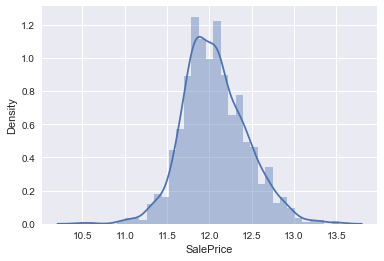

In [13]:
sns.distplot(y)

# BoxCox method
Helps to make the target normally distributed

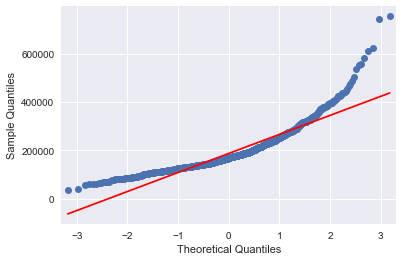

In [14]:
import statsmodels.api as sm
fig = sm.qqplot(data['SalePrice'],line = 's')

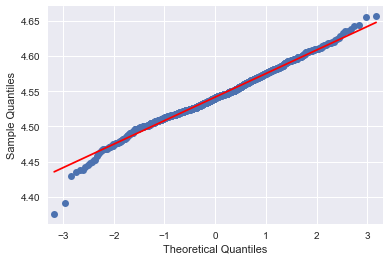

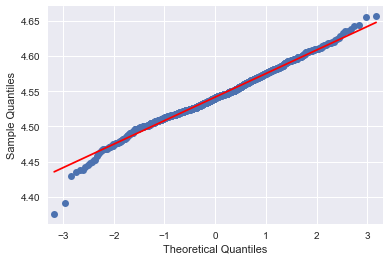

In [15]:
from scipy import stats
sample,lambd=stats.boxcox(data['SalePrice'])
sm.qqplot(sample,line='s')

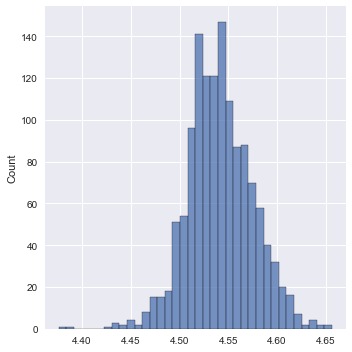

In [16]:
sns.displot(sample)

### Model

In [17]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(feature,y,test_size=0.2)

In [18]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
y_pred = model.fit(X_train,y_train).predict(X_test)

In [19]:
from sklearn.metrics import r2_score
score = r2_score(y_test,y_pred)

In [20]:
score

0.8303232237925218

In [21]:
from sklearn.model_selection import cross_val_score
cross_val_score(model,feature, y, cv = 10).mean()

0.8642438838689053